### Imports

In [79]:
from backtesting.test import EURUSD, GOOG



### Process parquet

In [80]:
import pandas as pd
import pyarrow.parquet as pq

DATA_PATH='/home/darrendube/Documents/spatialedge-hackathon-H1/v1/' 
FROM_DATE='20190101'
TO_DATE='20191231'
SYMBOL = 'AUDNZD'
TIMEFRAME = 'H1'

def read_and_process_parquet(data_path, from_date, to_date, symbol, timeframe):
    partition = ['symbol','timeframe', 'date', 'date']
    operator = ['=', '=', '>=', '<=']
    params = [symbol, timeframe, from_date, to_date]
            
    dataset = pq.ParquetDataset(data_path, filters=list(zip(partition, operator, params)), use_legacy_dataset=True)
    table = dataset.read()
    df = table.to_pandas()

    df['date'] = df['date'].astype(str)
    df['time'] = df['time'].astype(str)

    df['datetime'] = df['date'] + ' ' + df['time']
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S')
    df.set_index('datetime', inplace=True)

    df.drop(['time', 'symbol', 'timeframe', 'date'], axis=1, inplace=True)
    df = df.sort_values('datetime')
    df.fillna(method='ffill', inplace=True)

    return df 

data = read_and_process_parquet(DATA_PATH, FROM_DATE, TO_DATE, SYMBOL, TIMEFRAME)

/tmp/ipykernel_119961/1397213944.py:15: FutureWarning: Passing 'use_legacy_dataset=True' to get the legacy behaviour is deprecated as of pyarrow 11.0.0, and the legacy implementation will be removed in a future version.
  dataset = pq.ParquetDataset(data_path, filters=list(zip(partition, operator, params)), use_legacy_dataset=True)


OSError: Passed non-file path: /home/darrendube/Documents/spatialedge-hackathon-H1/v1/

### Create helper functions

In [ ]:
#data = EURUSD.copy()

# Relative Strength Index (RSI)
#close = data.Close.values


def RSI(values, period=168):
    delta = pd.Series(values).diff()
    gain = delta.where(delta>0.0)
    #gain.fillna(0, inplace=True) 
    loss = -delta.where(delta<0.0)
    #loss.fillna(0, inplace=True) #TODO: instead of replacing with 0, remove those vaues
    loss
    avg_gain = gain.rolling(period, min_periods=1).mean() # average gain over 7 day period (168hr) 
    avg_gain.fillna(0, inplace=True)
    avg_loss = loss.rolling(period, min_periods=1).mean() # average loss over 7 day period (168hr)
    avg_loss.fillna(0.000000001, inplace=True)
    rs = (avg_gain/avg_loss)
    rsi = 100-(100/(1+rs))
   
    return rsi

def SMA(values, n):
    
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

def Stochastic_Oscillator(values, period=168):
    '''Calculates stochastic oscillator'''
    time_period = period
    data = pd.Series(values)
    if len(values) < time_period:
        time_period = len(values)
    lowest_close_in_period = data.rolling(time_period, min_periods=1).min()
    highest_close_in_period = data.rolling(time_period, min_periods=1).max()
    so = ((data-lowest_close_in_period)/(highest_close_in_period-lowest_close_in_period))*100
    return so


def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


### Create features

In [ ]:
from feature_engine.timeseries.forecasting import LagFeatures

data.columns = ['Open','High','Low','Close','Volume']
rsi = RSI(data.Close, 168)
so14 = Stochastic_Oscillator(data.Close, 14)
so28 = Stochastic_Oscillator(data.Close, 28)
sma5 = SMA(data.Close, 5)
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
upper, lower = BBANDS(data, 20, 2)

data['X_RSI'] = rsi
data['X_SO14'] = so14
data['X_SO28'] = so28
data['X_DELTA_SO14'] = (so14-so28)/data.Close.values

data['X_SMA5']  = sma5
data['X_SMA10'] = sma10
data['X_SMA20'] = sma20
data['X_SMA50'] = sma50
data['X_DELTA_SMA10'] = (sma10-sma20) / data.Close.values
data['X_DELTA_SMA20'] = (sma50-sma20) / data.Close.values

data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - data.Close) / data.Close
data['X_BB_lower'] = (lower - data.Close) / data.Close
data['X_BB_width'] = (upper - lower) / data.Close
data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour






In [ ]:
data.head()

,Open,High,Low,Close,Volume,X_RSI,X_SO14,X_SO28,X_DELTA_SO14,X_SMA5,...,X_SMA50,X_DELTA_SMA10,X_DELTA_SMA20,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,X_Sentiment,X_day,X_hour
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 22:00:00,1.050025,1.050120,1.048810,1.049455,5045.500000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1,22
2019-01-01 23:00:00,1.049415,1.050040,1.047960,1.049975,15702.720000,99.999808,100.000000,100.000000,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1,23
2019-01-02 00:00:00,1.049975,1.049990,1.048430,1.049065,14696.279973,36.363636,0.000000,0.000000,0.0,NaN,...,NaN,NaN,NaN,-0.000372,NaN,NaN,NaN,True,2,0
2019-01-02 01:00:00,1.049060,1.049315,1.047860,1.048030,18878.009980,34.840871,0.000000,0.000000,0.0,NaN,...,NaN,NaN,NaN,-0.001852,NaN,NaN,NaN,True,2,1
2019-01-02 02:00:00,1.048030,1.048860,1.047275,1.048810,26223.359979,40.061633,40.102828,40.102828,0.0,1.049067,...,NaN,NaN,NaN,-0.000243,NaN,NaN,NaN,True,2,2


In [ ]:
# Lagging price indicator
#data['X_LAG1'] = data.Close.shift(24)
lf = LagFeatures(periods=2, variables = ["Close"])

In [ ]:
data.index.value_counts()


datetime
2019-03-11 00:00:00    2
2019-09-03 08:00:00    1
2019-09-02 06:00:00    1
2019-09-02 05:00:00    1
2019-09-02 04:00:00    1
                      ..
2019-05-02 06:00:00    1
2019-05-02 05:00:00    1
2019-05-02 04:00:00    1
2019-05-02 03:00:00    1
2019-05-02 15:00:00    1
Name: count, Length: 6232, dtype: int64

In [ ]:
data = data[~data.index.duplicated(keep='first')]
data[data.index=='2019-03-11 00:00:00']

,Open,High,Low,Close,Volume,X_RSI,X_SO14,X_SO28,X_DELTA_SO14,X_SMA5,...,X_SMA50,X_DELTA_SMA10,X_DELTA_SMA20,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,X_Sentiment,X_day,X_hour
datetime,,,,,,,,,,,,,,,,,,,,,
2019-03-11,1.034535,1.035005,1.03417,1.034415,13333.529997,49.702841,0.0,0.0,0.0,1.034879,...,1.037174,-0.000222,0.001682,-0.000444,0.002134,-0.000121,0.002254,True,0,0


In [ ]:
len(data.index.unique())

6232

In [ ]:
lf.fit_transform(data)

,Open,High,Low,Close,Volume,X_RSI,X_SO14,X_SO28,X_DELTA_SO14,X_SMA5,...,X_DELTA_SMA10,X_DELTA_SMA20,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,X_Sentiment,X_day,X_hour,Close_lag_2
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 22:00:00,1.050025,1.050120,1.048810,1.049455,5045.500000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,1,22,NaN
2019-01-01 23:00:00,1.049415,1.050040,1.047960,1.049975,15702.720000,99.999808,100.000000,100.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,1,23,NaN
2019-01-02 00:00:00,1.049975,1.049990,1.048430,1.049065,14696.279973,36.363636,0.000000,0.000000,0.000000,NaN,...,NaN,NaN,-0.000372,NaN,NaN,NaN,True,2,0,1.049455
2019-01-02 01:00:00,1.049060,1.049315,1.047860,1.048030,18878.009980,34.840871,0.000000,0.000000,0.000000,NaN,...,NaN,NaN,-0.001852,NaN,NaN,NaN,True,2,1,1.049975
2019-01-02 02:00:00,1.048030,1.048860,1.047275,1.048810,26223.359979,40.061633,40.102828,40.102828,0.000000,1.049067,...,NaN,NaN,-0.000243,NaN,NaN,NaN,True,2,2,1.049065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 10:00:00,1.041265,1.041600,1.040715,1.040935,6027.830006,47.925828,55.021834,59.368836,-4.176055,1.041296,...,0.000580,0.000383,-0.000989,0.000879,-0.001735,0.002615,True,1,10,1.041965
2019-12-31 11:00:00,1.040935,1.041025,1.040180,1.040750,6715.600003,48.210867,42.823529,52.071006,-8.885397,1.041194,...,0.000571,0.000321,-0.000490,0.001058,-0.001472,0.002531,True,1,11,1.041260
2019-12-31 12:00:00,1.040755,1.040895,1.040320,1.040680,7030.729997,48.792146,39.529412,49.309665,-9.397945,1.041118,...,0.000516,0.000281,-0.000245,0.001113,-0.001303,0.002416,True,1,12,1.040935


In [ ]:

data.dropna().astype(float)

,Open,High,Low,Close,Volume,X_RSI,X_SO14,X_SO28,X_DELTA_SO14,X_SMA5,...,X_SMA50,X_DELTA_SMA10,X_DELTA_SMA20,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,X_Sentiment,X_day,X_hour
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-03 23:00:00,1.046905,1.048400,1.046230,1.047615,27817.440016,51.048478,32.808989,66.108319,-31.785847,1.046792,...,1.047814,-0.000450,-0.000126,0.000826,0.002412,-0.001919,0.004331,1.0,3.0,23.0
2019-01-04 00:00:00,1.047610,1.047935,1.046885,1.047340,36697.709998,51.703609,26.629213,63.355780,-35.066518,1.046954,...,1.047772,-0.000603,-0.000170,0.000411,0.002673,-0.001632,0.004305,1.0,4.0,0.0
2019-01-04 01:00:00,1.047350,1.048295,1.046670,1.048140,27457.249957,51.536551,44.606742,72.334456,-26.454208,1.047351,...,1.047735,-0.000631,-0.000235,0.000501,0.001911,-0.002347,0.004258,1.0,4.0,1.0
2019-01-04 02:00:00,1.048140,1.048925,1.047655,1.048690,28637.489951,51.114675,56.966292,74.415498,-16.639050,1.047739,...,1.047727,-0.000754,-0.000330,0.001289,0.001420,-0.002763,0.004183,1.0,4.0,2.0
2019-01-04 03:00:00,1.048685,1.049320,1.048055,1.048090,24530.299994,51.406872,66.494845,45.385451,20.140823,1.047975,...,1.047729,-0.000751,-0.000343,-0.000048,0.002038,-0.002157,0.004195,1.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 10:00:00,1.041265,1.041600,1.040715,1.040935,6027.830006,47.925828,55.021834,59.368836,-4.176055,1.041296,...,1.040870,0.000580,0.000383,-0.000989,0.000879,-0.001735,0.002615,1.0,1.0,10.0
2019-12-31 11:00:00,1.040935,1.041025,1.040180,1.040750,6715.600003,48.210867,42.823529,52.071006,-8.885397,1.041194,...,1.040872,0.000571,0.000321,-0.000490,0.001058,-0.001472,0.002531,1.0,1.0,11.0
2019-12-31 12:00:00,1.040755,1.040895,1.040320,1.040680,7030.729997,48.792146,39.529412,49.309665,-9.397945,1.041118,...,1.040871,0.000516,0.000281,-0.000245,0.001113,-0.001303,0.002416,1.0,1.0,12.0


In [ ]:
EURUSD

,Open,High,Low,Close,Volume
2017-04-19 09:00:00,1.07160,1.07220,1.07083,1.07219,1413
2017-04-19 10:00:00,1.07214,1.07296,1.07214,1.07260,1241
2017-04-19 11:00:00,1.07256,1.07299,1.07170,1.07192,1025
2017-04-19 12:00:00,1.07195,1.07280,1.07195,1.07202,1460
2017-04-19 13:00:00,1.07200,1.07230,1.07045,1.07050,1554
...,...,...,...,...,...
2018-02-07 11:00:00,1.23390,1.23548,1.23386,1.23501,2203
2018-02-07 12:00:00,1.23501,1.23508,1.23342,1.23422,2325
2018-02-07 13:00:00,1.23422,1.23459,1.23338,1.23372,2824
2018-02-07 14:00:00,1.23374,1.23452,1.23238,1.23426,4065


# Feature Importance

### Create matrix

In [ ]:
import numpy as np

def get_X(data):
    return data.filter(like='X').values

def get_y(data):
    y = data.Close.pct_change(48).shift(-48)
    y[y.between(-.004,.004)] = 0
    y[y > 0] = 1
    y[y < 0] = -1
    return y

def get_clean_Xy(df):
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y



### Test model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split



X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .5, random_state=0)


In [ ]:
# Xtrain
data2 = pd.Series(y_train) + pd.DataFrame(X_train) 
data2

,0,1,2,3,4,5,6,7,8,9,...,3082,3083,3084,3085,3086,3087,3088,3089,3090,3091
0,50.362317,30.243902,25.889571,4.094514,0.063712,1.06354,1.06421,1.063553,-0.000629,-0.000618,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48.984839,32.478632,26.388889,5.836526,0.04352,1.043423,1.044203,1.044644,-0.000748,0.000422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50.43425,0.0,0.0,0.0,0.074643,1.0756,1.075738,1.07504,-0.000129,-0.000651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44.382345,0.0,45.00846,-42.060247,0.070432,1.070559,1.070527,1.069996,0.000029,-0.000496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45.097099,75.528169,71.73913,3.619518,0.047205,1.046471,1.046081,1.046713,0.000373,0.000604,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3087,52.127582,100.0,81.210593,17.458056,0.074374,1.073757,1.073806,1.074864,-0.000045,0.000984,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3088,52.399681,25.910931,20.414673,5.248628,0.047481,1.04731,1.047826,1.048876,-0.000493,0.001003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3089,57.717244,100.0,100.0,0.0,0.056951,1.056134,1.055171,1.055016,0.000911,-0.000147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3090,48.400213,0.0,0.0,0.0,0.059994,1.060283,1.060596,1.061394,-0.000295,0.000753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2', C=1.0)
model.fit(X_train, y_train)


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Classification accuracy:  0.9738033635187581
              precision    recall  f1-score   support

        -1.0       0.91      0.98      0.95       427
         0.0       0.98      0.98      0.98      2210
         1.0       0.99      0.93      0.96       455

    accuracy                           0.97      3092
   macro avg       0.96      0.96      0.96      3092
weighted avg       0.97      0.97      0.97      3092



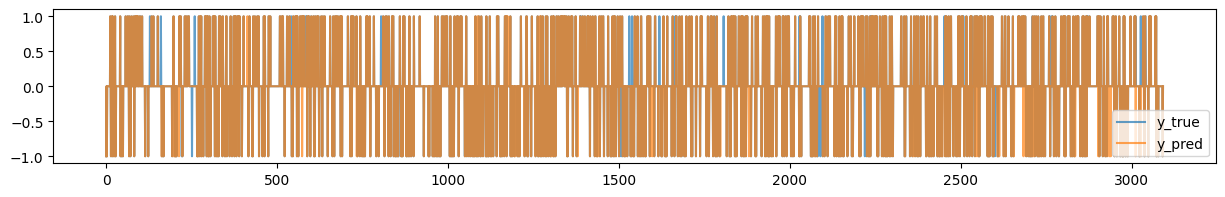

In [ ]:



model = DecisionTreeClassifier()
#pd.DataFrame(X)
model.fit(X,y)
y_pred = model.predict(X_test)
#_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)

print('Classification accuracy: ', np.mean(y_test == y_pred))
print(classification_report(y_test, y_pred))

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)


In [ ]:
X.shape

(6184, 17)

### Strategy based on Relative Strength Index

In [ ]:
%%time

from backtesting import Strategy, Backtest
from backtesting.lib import crossover

    
class RulesBasedStrategy(Strategy):
    # TODO: add rules based
    # The SMA periods
    n1 = 10
    n2 = 20

    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        #self.rsi = self.I(RSI, self.data.Close, 23) # Calculate 1 day rsi
        #self.stochastic_oscillator = self.I(Stochastic_Oscillator, self.data.Close, 168)

    #def next(self):
    #    # If all indicators say you should buy, buy
    #    if self.rsi < 30 or self.stochastic_oscillator< 20 or crossover(self.sma1, self.sma2):
    #        self.buy()
    #        self.position.close()
    #    
    #    # If all indicators say you should sell, sell
    #    elif self.rsi > 70 or self.stochastic_oscillator > 80 or crossover(self.sma2, self.sma1):
    #        self.position.close()
    #        self.sell()
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()

CASH = 1000000        
COMMISSION=0.002
N_TRAIN = 4000

class MLStrategy(Strategy):    
    price_delta = .004

    def init(self):
        self.clf = DecisionTreeClassifier()
        df = self.data.df.iloc[:N_TRAIN]
        X,y = get_clean_Xy(df)

        self.clf.fit(X,y)

        self.tpo = False
        self.I(get_y, self.data.df, name='y_true')
        
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name = 'forecast')

    def next(self):
        if len(self.data) < N_TRAIN: return

        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]
        
        forecast = self.clf.predict(get_X(self.data.df.iloc[-1:]))

        self.forecasts[-1] = forecast
        
        upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)

        #if not self.tpo:
        #    if forecast == 1:
        #        self.position.close()
        #        self.buy()
        #    elif forecast == -1:
        #        self.position.close()
        #        self.sell()
        
        #if self.equity > CASH*1.1: # If equity i500 ever 10% higher than starting cash, close position and cease trading
        #    self.position.close()
        #    self.tpo=True




        

CPU times: user 159 µs, sys: 0 ns, total: 159 µs
Wall time: 170 µs


### Backtest

In [ ]:

bt = Backtest(data, MLStrategy, cash=CASH, commission=COMMISSION)
stats = bt.run()
stats

<timed exec>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<timed exec>:67: DeprecationWarning: Conversion 

Start                     2019-01-01 22:00:00
End                       2019-12-31 14:00:00
Duration                    363 days 16:00:00
Exposure Time [%]                   84.611682
Equity Final [$]                938915.189571
Equity Peak [$]                1000230.553038
Return [%]                          -6.108481
Buy & Hold Return [%]               -0.854253
Return (Ann.) [%]                   -4.948021
Volatility (Ann.) [%]                0.749661
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -6.154422
Avg. Drawdown [%]                   -3.103173
Max. Drawdown Duration      337 days 16:00:00
Avg. Drawdown Duration      169 days 12:00:00
# Trades                                  184
Win Rate [%]                             37.5
Best Trade [%]                       0.341505
Worst Trade [%]                     -0.607758
Avg. Trade [%]                    

In [ ]:
bt.plot()

/home/darrendube/.local/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/home/darrendube/.local/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p7099', ...)